# Preparation and Training of basic Sentiment Analysis Model

The goal of this project is to train a basic sentiment calssifier using the IMDB dataset.The dataset contains 50,000 reviews, with 25,000 labeled for training and 25,000 labeled for testing.

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

#datasets
import opendatasets as od

# text preprocessing
import re
import nltk
import nltk.corpus
#nltk resources
nltk.download('stopwords')
nltk.download('punkt_tab') # new version of punkt tokenizer after punkt was deprecated after pickle vulnerability
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# model storage
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louislepage/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/louislepage/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/louislepage/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The first step is to download the dataset from Kaggle.
The dataset is available at https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews .

We use opendatasets to download the dataset. Make sure you have your Kaggle API key and username ready!

In [2]:
# download the dataset, this will also create a dir containing the data
if not os.path.exists('imdb-dataset-of-50k-movie-reviews'):
    od.download('https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

In [3]:
# load into notebook
data = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Preparation
We will start with some insights and check if we have any missing values etc.

In [4]:
data.describe()


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
# the freq of reviews is only 5, meaning the most repeated review has a freq of 5
# to check what all the actual freqs are, we can use value_counts
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
# looks good, very balanced dataset, lets check for missing values
data.isnull().sum()

review       0
sentiment    0
dtype: int64

No missing values, what about duplicates?
We already know that the freq of the most repeated review is 5, but are there more duplicates?

In [7]:
data['review'].duplicated().sum()

418

Looks good! Usually we would have to remove duplicates, but in this case we can keep them, they are only a few compared to the total dataset

# Data Preprocessing
We now understand the data, and can start with the preprocessing.

1) Convert labels to numerical values
2) Preprocess Text
    - Convert text to lowercase
    - Remove special characters like html tags, punctuation etc.
    - Remove stopwords
    - Stemming or Lemmatization

In [8]:
# get values of the sentiment column
data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [9]:
# step 1 convert labels to numerical values
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

In [10]:
# step 2 preprocess text
stopwords = set(nltk.corpus.stopwords.words('english')) - {"not"}
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    
    # remove html tags (might not be necessary in this dataset, but let's do it for practice)
    text = re.sub(r'<.*?>', ' ', text)
    
    # remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in stopwords]
    
    # lemmatize
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)

In [11]:
# apply the preprocessing function to the review column
data['review_clean'] = data['review'].apply(preprocess_text)
data.head()

,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


This leaves us with a clean dataset. Lets first try to get an understanding of the data by visualizing it.

In [12]:
data['word_count'] = data['review_clean'].apply(lambda x: len(x.split()))

Text(0.5, 0, 'Word Count')

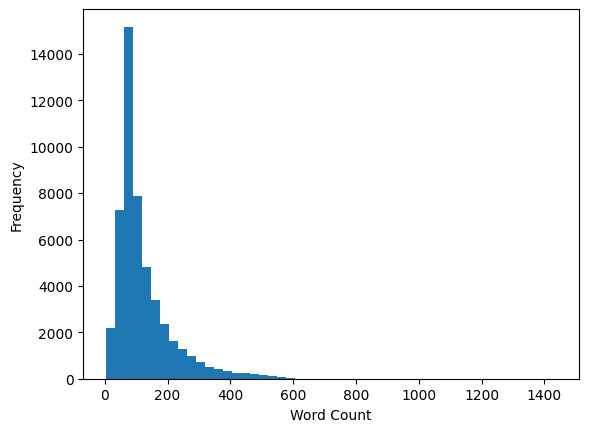

In [13]:
data['word_count'].plot(kind='hist', bins=50)
plt.xlabel('Word Count')

The word count seems to be distributed normally, with a mean of around 100 words. This is a good sign, as it means that the reviews are not too short or too long.  Let's do some n-gram analysis to get a better understanding of the words and context.

In [14]:
# n-gram analysis

# computes the freq of n-grams for the given corpus
def get_n_grams(corpus, ngram=1, top_n=10):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(ngram, ngram))

    # Fit and transform the corpus
    X = vectorizer.fit_transform(corpus)

    # Extract n-gram names and convert to feature matrix
    vocabulary = vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0)
    
    #combine
    ngram_counts = [(word, freqs[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    #sort
    ngram_counts = sorted(ngram_counts, key=lambda x: x[1], reverse=True)
    
    # make dataframe
    ngram_counts = pd.DataFrame(ngram_counts, columns=['ngram', 'count'])
    return ngram_counts[:top_n]

In [15]:
positive_data = data[data['sentiment'] == 1]
negative_data = data[data['sentiment'] == 0]

In [16]:
# get unigrams
positive_unigrams = get_n_grams(positive_data['review_clean'], 1, 20)
negative_unigrams = get_n_grams(negative_data['review_clean'], 1, 20)
positive_unigrams.head()

,ngram,count
0,film,48746
1,movie,43918
2,not,28981
3,one,27534
4,like,17664


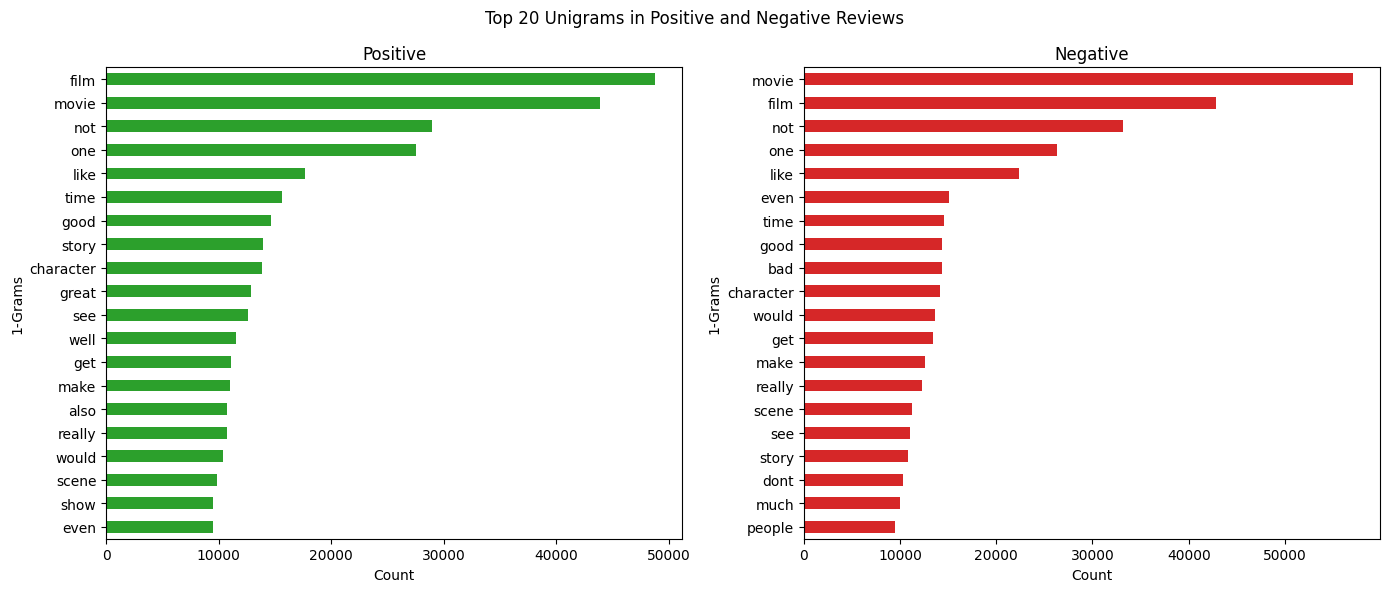

In [17]:
# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

fig.suptitle('Top 20 Unigrams in Positive and Negative Reviews')

# Plot positive unigrams
positive_unigrams.sort_values(by='count').plot(
    kind='barh', x='ngram', y='count', color='tab:green', ax=axes[0], legend=False
)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('1-Grams')
axes[0].set_title('Positive')

# Plot negative unigrams
negative_unigrams.sort_values(by='count').plot(
    kind='barh', x='ngram', y='count', color='tab:red', ax=axes[1], legend=False
)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('1-Grams')
axes[1].set_title('Negative')

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
# get bigrams
positive_bigrams = get_n_grams(positive_data['review_clean'], 2, 20)
negative_bigrams = get_n_grams(negative_data['review_clean'], 2, 20)
positive_bigrams.head()

,ngram,count
0,one best,1643
1,ive seen,1095
2,even though,1060
3,film not,958
4,ever seen,950


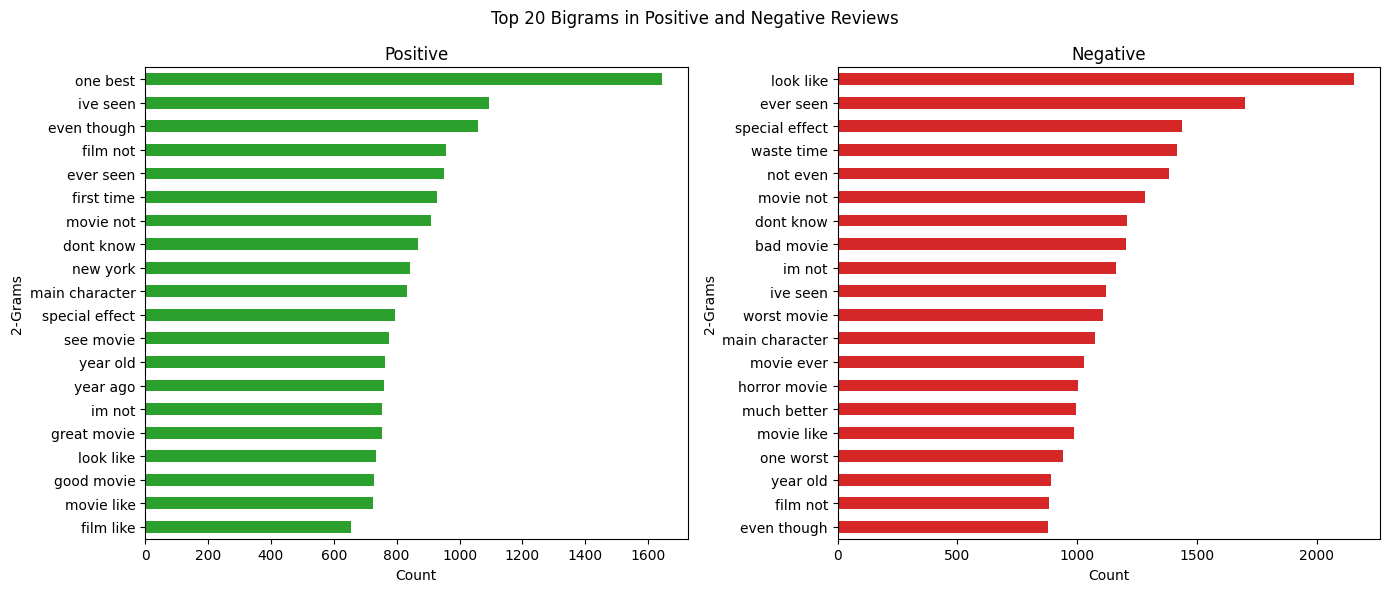

In [19]:
# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

fig.suptitle('Top 20 Bigrams in Positive and Negative Reviews')

# Plot positive unigrams
positive_bigrams.sort_values(by='count').plot(
    kind='barh', x='ngram', y='count', color='tab:green', ax=axes[0], legend=False
)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('2-Grams')
axes[0].set_title('Positive')

# Plot negative unigrams
negative_bigrams.sort_values(by='count').plot(
    kind='barh', x='ngram', y='count', color='tab:red', ax=axes[1], legend=False
)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('2-Grams')
axes[1].set_title('Negative')

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
# get trigrams
positive_trigrams = get_n_grams(positive_data['review_clean'], 3, 20)
negative_trigrams = get_n_grams(negative_data['review_clean'], 3, 20)
positive_trigrams.head()

,ngram,count
0,ive ever seen,363
1,new york city,193
2,im not sure,187
3,film ever made,164
4,film ive seen,164


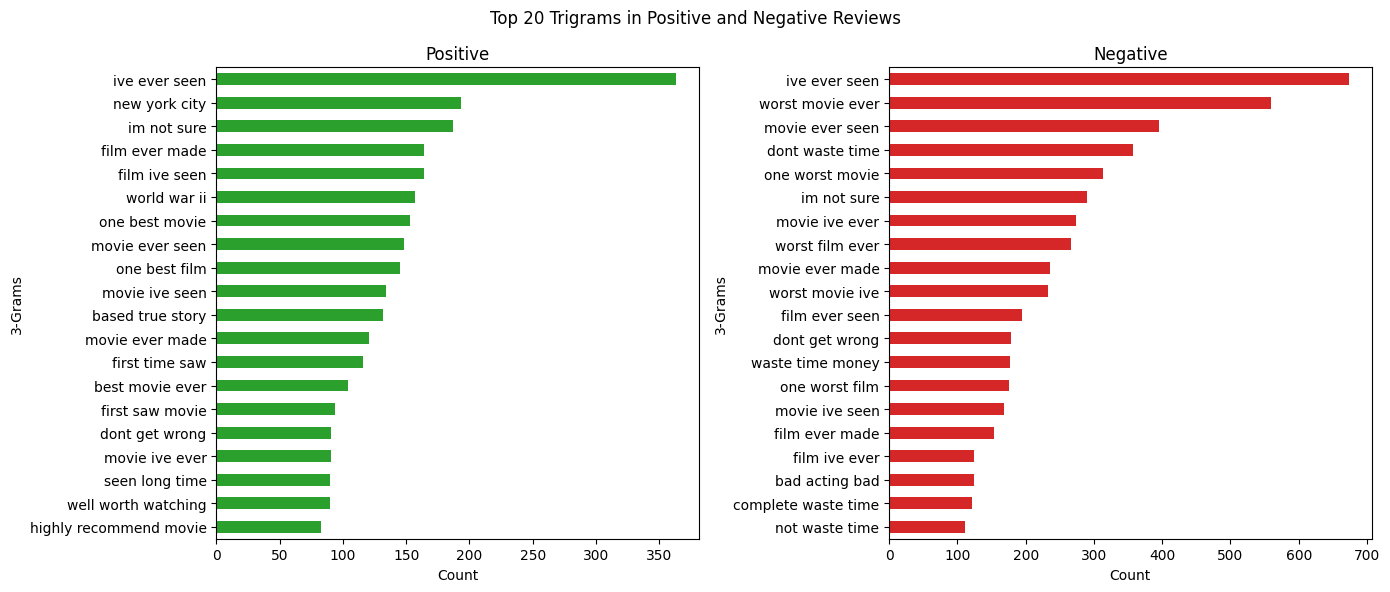

In [21]:
# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

fig.suptitle('Top 20 Trigrams in Positive and Negative Reviews')

# Plot positive unigrams
positive_trigrams.sort_values(by='count').plot(
    kind='barh', x='ngram', y='count', color='tab:green', ax=axes[0], legend=False
)
axes[0].set_xlabel('Count')
axes[0].set_ylabel('3-Grams')
axes[0].set_title('Positive')

# Plot negative unigrams
negative_trigrams.sort_values(by='count').plot(
    kind='barh', x='ngram', y='count', color='tab:red', ax=axes[1], legend=False
)
axes[1].set_xlabel('Count')
axes[1].set_ylabel('3-Grams')
axes[1].set_title('Negative')

# Adjust layout
plt.tight_layout()
plt.show()

Well, from this it looks like movies in NYC about WW2 should be great. Jokes aside, this gives us a good understanding of the context of the reviews.

# Model Training
To train the model, we will first clean up the dataframe so we only have the columns we need.
Then we will split the data into training and testing sets.

Since it can be tricky to find a good classifier, lets train a few and compare them.

In [22]:
data.drop(columns=['review', 'word_count'], inplace=True)

Since we do basic NLP and no deeplearning, we saw that there were some words a lot more frequent than other, we will use TF-IDF to normalize the data and vectorize it.

In [23]:
# create vectorizer
tf_idf = TfidfVectorizer(max_features=5000, ngram_range = (2,2))

# fit and transform the data into feature matrix
X = tf_idf.fit_transform(data['review_clean'])
X.shape

(50000, 5000)

In [24]:
# target variable
y = data['sentiment']

At this point, you might want to resample the data if it is imbalanced. In this case, we have a balanced dataset, so we can move on.

# Split the data into training and testing sets

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection
Let's try a few classifiers and see which one performs best with basic parameters. We will use cross validation for this.

If you have limited time, you could skip this, since I already ran it. The final model is retraiend below.

In [70]:

logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
svc = SVC()
naive_bayes = MultinomialNB()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()

models = {
    'Logistic Regression': logistic_regression,
    'Random Forest': random_forest,
    'SVC': svc,
    'Naive Bayes': naive_bayes,
    'KNN': knn,
    'Decision Tree': dtree
}

for name, model in models.items():
    print(f'Training {name} model with 5 fold cross validation...')
    start = time.time()
    score = cross_val_score(model, X_train, y_train, cv=5)
    end = time.time()
    print(f'Accuracy: {score.mean()}, Time taken: {end - start:.2f} seconds')

Training Logistic Regression model with 5 fold cross validation...
Accuracy: 0.819975, Time taken: 0.63 seconds
Training Random Forest model with 5 fold cross validation...
Accuracy: 0.7838, Time taken: 80.95 seconds
Training SVC model with 5 fold cross validation...
Accuracy: 0.818125, Time taken: 1013.01 seconds
Training Naive Bayes model with 5 fold cross validation...
Accuracy: 0.8204499999999999, Time taken: 0.04 seconds
Training KNN model with 5 fold cross validation...
Accuracy: 0.510675, Time taken: 13.30 seconds
Training Decision Tree model with 5 fold cross validation...
Accuracy: 0.7111750000000001, Time taken: 38.90 seconds


From this, we see that all models perform well, with the exception of KNN.
While Naive Bayes is the fastest, SVC and Logistic Regression are also reasonable choices and probably perform better in more complex situations.
However, since SVC took extremely long to train, compared to the other models, we will go with Logistic Regression and Naive Bayes into the next round for parameter tuning.

# Hyperparameter Tuning

Since I already ran this, you could skip this part and go directly to the model evaluation where the params are known.

In [ ]:
# logistic regression

params_logreg = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2']
}

grid_search_logreg = GridSearchCV(LogisticRegression(random_state=42, solver='saga'), params_logreg, cv=5, scoring='accuracy', verbose=1)

grid_search_logreg.fit(X_train, y_train)

print('Best Accuracy for Logistic Regression:', grid_search_logreg.best_score_)
print('Best parameters for Logistic Regression:', grid_search_logreg.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/louislepage/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louislepage/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louislepage/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louislepage/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louislepage/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louislepage/pyenv/lib/python3.9/site-packages/sklearn

This shows that the best parameters for Logistic Regression are C=0.615848211066026, penalty='l2'.The errors/warnigns come from suboptimal parameter combinations, where the model did not converge. We can ignore these

In [26]:
# naive bayes
params_bayes = {
    'alpha': np.logspace(-3, 1, 20)
}

grid_search_bayes = GridSearchCV(MultinomialNB(), params_bayes, cv=5, scoring='accuracy', verbose=1)

grid_search_bayes.fit(X_train, y_train)

print('Best Accuracy for Naive Bayes:', grid_search_bayes.best_score_)
print('Best parameters for Naive Bayes:', grid_search_bayes.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Accuracy for Naive Bayes: 0.820575
Best parameters for Naive Bayes: {'alpha': 0.5455594781168515}


This shows that the best parameters for Naive Bayes are alpha=0.18329807108324356.

# Model Evaluation
Since both are still very similar, we will evaluate both models on the test set.
We could get them from gridsearch, but we will train them again for clarity and to give the option to get them directly without the long runtimes of gridsearch.

In [27]:
# logistic regression
best_linlogreg = LogisticRegression(C=0.615848211066026, penalty='l2', random_state=42, solver='saga')
best_linlogreg.fit(X_train, y_train)

# naive bayes
best_bayes = MultinomialNB(alpha=0.18329807108324356)
best_bayes.fit(X_train, y_train)

# prediction
y_pred_linlogreg = best_linlogreg.predict(X_test)
y_pred_bayes = best_bayes.predict(X_test)

# basic accuracy
print('Accuracy for Logistic Regression:', accuracy_score(y_test, y_pred_linlogreg))
print('Accuracy for Naive Bayes:', accuracy_score(y_test, y_pred_bayes))

Accuracy for Logistic Regression: 0.8306
Accuracy for Naive Bayes: 0.8278


This is a reasonably good result, so far the regression model seems to generalize better.
We can also check the confusion matrix and classification report to get a better understanding of the models.

In [28]:
# confusion matrix and classification report
confm_linlogreg = confusion_matrix(y_test, y_pred_linlogreg)
confm_bayes = confusion_matrix(y_test, y_pred_bayes)

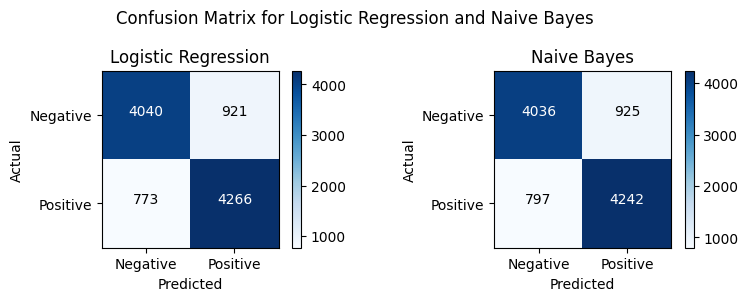

In [31]:
# plot confusion matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

fig.suptitle('Confusion Matrix for Logistic Regression and Naive Bayes')

# Plot Logistic Regression
plt.subplot(1, 2, 1)
plt.title('Logistic Regression')
plt.imshow(confm_linlogreg, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()

# add values to plot
for i in range(confm_linlogreg.shape[0]):
    for j in range(confm_linlogreg.shape[1]):
      plt.text(j, i, confm_linlogreg[i, j], horizontalalignment = "center", color = "white" if confm_linlogreg[i, j] > confm_linlogreg.max() / 2 else "black")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.grid(False)

# Plot Naive Bayes
plt.subplot(1, 2, 2)
plt.title('Naive Bayes')
plt.imshow(confm_bayes, cmap='Blues', interpolation='nearest')
plt.colorbar()

# add values to plot
for i in range(confm_bayes.shape[0]):
    for j in range(confm_bayes.shape[1]):
      plt.text(j, i, confm_bayes[i, j], horizontalalignment = "center", color = "white" if confm_bayes[i, j] > confm_bayes.max() / 2 else "black")
        
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.grid(False)

plt.tight_layout()
plt.show()

The confusion matrix shows that the models are very similar, with the regression model having a slight edge in the number of correct predictions. The classification report will give us more insights.

In [34]:
# classification report
print('Classification Report for Logistic Regression:')
print(classification_report(y_test, y_pred_linlogreg))

print('Classification Report for Naive Bayes:')
print(classification_report(y_test, y_pred_bayes))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      4961
           1       0.82      0.85      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      4961
           1       0.82      0.84      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000


The classification report confirms that the models are very similar, with the regression model having a slight edge in the number of correct predictions. Since both are so similar, we should consider both models from a usability perspective. The regression model is more interpretable, while the Naive Bayes model is faster to train and predict. The final choice depends on the use case.

Given my background in explainable AI, I love an interpretable model, so I would go with the regression model. However, if you need a fast model, the Naive Bayes model is a good choice.

# Saving the Model
Although this is a simple model, you would usually save it for later use. We will save the regression model as a pickle file.

In [35]:
# save the model
filename = 'sentiment_model_logreg.pkl'
pickle.dump(best_linlogreg, open(filename, 'wb'))

# Recap
We now went through the process of finding a good model for sentiment analysis. We started with data preparation, then went through the preprocessing steps, and finally trained and evaluated some models to find the best fit. We also saved the model for later use.

---


## Data Preparation
We used the IMDB dataset, which contains 50,000 reviews. The dataset was balanced, with 25,000 reviews labeled as positive and 25,000 as negative. We did not have any missing values, but we did have some duplicates, which we kept.

---

## Data Preprocessing
We converted the labels to numerical values and preprocessed the text by converting it to lowercase, removing special characters, removing stopwords, and lemmatizing the text. We also did some n-gram analysis to understand the context of the reviews.

---

## Model Training to find best Model
We used TF-IDF to normalize the data and vectorize it. We split the data into training and testing sets and trained several classifiers to find the best one. We then used cross-validation to evaluate the models and selected Logistic Regression and Naive Bayes for further tuning.

---

## Hyperparameter Tuning
We used GridSearchCV to find the best parameters for Logistic Regression and Naive Bayes.
Even after hyperparameter tuning, both models performed similarly, with Logistic Regression having a slight edge.
To find the best model for sentiment analysis, we evaluated both models on the test set.

---

## Model Evaluation
We evaluated the models using accuracy, confusion matrix, and classification report. Both models performed well, with Logistic Regression having a slight edge in the number of correct predictions. Since both models are very similar, the final choice depends on the use case. The regression model is more interpretable, while the Naive Bayes model is faster to train and predict.

In most cases, a good interpretable model is preferred, since we could compute shape values and explain the model to stakeholders.

---

## Saving the Model
We saved the regression model as a pickle file for later use. This would be especially useful if we wanted to deploy the model in a production environment and the model training took a long time.

# Credits
Your only as good as the people you learn from. I would like to thank the following people for their great content and inspiration:

1) [Olga Davydova at Data Monsters](https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908) for a great article on text preprocessing.
2) [Abdelrahman Mohamed](https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56) for a great article on sentiment analysis.
3) [Richard Rivaldo](https://github.com/RichardRivaldo/Sentiment-Analysis?tab=readme-ov-file) for his notebook on sentiment analysis.